In [1]:
import sys
sys.path.append("../src")

import pandas as pd
import matplotlib.pyplot as plt
from data_loader import download_stock_data, save_to_csv
from feature_engineering import add_basic_features
from model import train_model


In [2]:
df = download_stock_data("AAPL", "2010-01-01", "2024-12-31")
save_to_csv(df, "../data/SP500.csv")
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,2010-01-04,6.440331,6.455077,6.391278,6.422877,493729600
1,2010-01-05,6.451465,6.487878,6.417459,6.458086,601904800
2,2010-01-06,6.348847,6.477046,6.342227,6.451467,552160000
3,2010-01-07,6.337110,6.379843,6.291067,6.372319,477131200
4,2010-01-08,6.379241,6.379843,6.291368,6.328683,447610800


In [3]:
from technical_indicators import add_technical_indicators

# Add RSI, Bollinger Bands, MACD
df = add_technical_indicators(df)
df.head()


Price,Date,Close,High,Low,Open,Volume,RSI,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal
19,2010-02-01,5.860127,5.898346,5.756906,5.789107,749876400,38.180167,6.624758,5.837964,-0.122075,-0.077465
20,2010-02-02,5.894132,5.907976,5.819500,5.895637,698342400,40.705332,6.611935,5.796167,-0.129448,-0.087862
21,2010-02-03,5.995546,6.024737,5.850796,5.873366,615328000,41.111362,6.581813,5.780697,-0.125659,-0.095421
22,2010-02-04,5.779476,5.969667,5.765030,5.920313,757652000,37.621054,6.583026,5.722548,-0.138495,-0.104036
23,2010-02-05,5.882095,5.898346,5.743364,5.796931,850306800,42.533155,6.567300,5.692772,-0.138788,-0.110986


In [4]:
df = add_basic_features(df)
df.head()


Price,Date,Close,High,Low,Open,Volume,RSI,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Return,MA_5,MA_10
28,2010-02-12,6.030156,6.068074,5.883299,5.961843,655468800,47.205576,6.431796,5.631433,-0.105026,-0.118973,0.008607,5.925309,5.903792
29,2010-02-16,6.121038,6.129765,6.064462,6.077101,543737600,47.369504,6.422773,5.632843,-0.084698,-0.112118,0.015071,5.981163,5.929883
30,2010-02-17,6.095460,6.148424,6.044601,6.144813,436396800,44.352678,6.346744,5.671285,-0.069847,-0.103664,-0.004179,6.019443,5.950016
31,2010-02-18,6.106893,6.135783,6.046405,6.067771,422825200,54.668999,6.291821,5.699726,-0.056503,-0.094232,0.001876,6.066449,5.961151
32,2010-02-19,6.068975,6.115019,6.052123,6.074694,415469600,64.556246,6.257267,5.715019,-0.048429,-0.085071,-0.006209,6.084505,5.990101


In [5]:
model, X_test, y_test, y_pred, rmse = train_model(df)
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 24.161409241676264


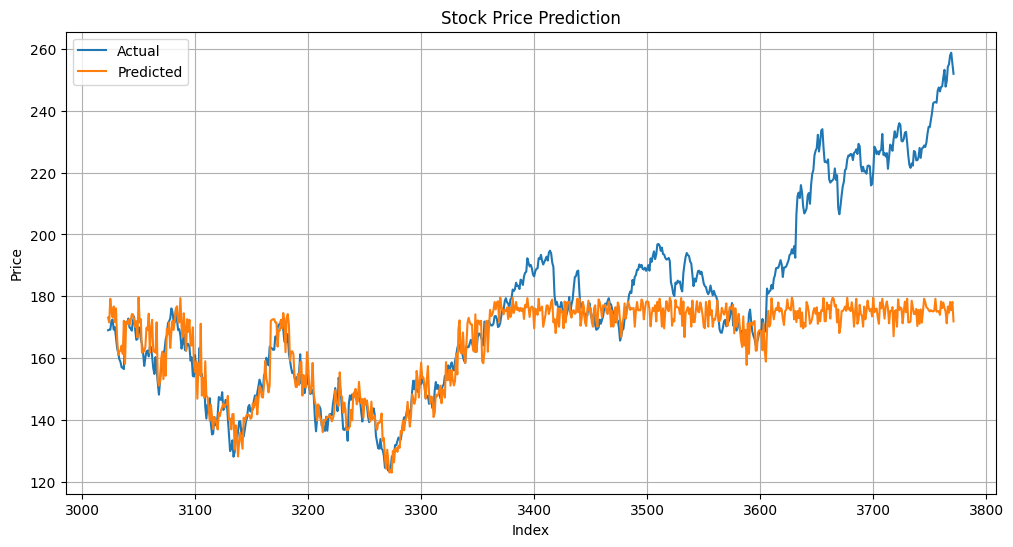

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.title("Stock Price Prediction")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.savefig("../plots/aapl_forecast.png")
plt.show()


In [7]:
import numpy as np

# Direction of real and predicted prices
actual_direction = np.sign(y_test.values[1:] - y_test.values[:-1])
predicted_direction = np.sign(y_pred[1:] - y_pred[:-1])

# Accuracy of direction prediction
directional_accuracy = (actual_direction == predicted_direction).mean()
print(f"Directional Accuracy: {directional_accuracy:.2%}")


Directional Accuracy: 51.20%


In [8]:
# Simulated trading strategy:
# Buy when prediction increases, hold/cash otherwise
signals = np.sign(np.append([0], np.diff(y_pred)))
returns = np.append([0], np.diff(y_test.values))

# Strategy return: only earn when signal matches price move
strategy_returns = signals * returns
cumulative_returns = np.cumsum(strategy_returns)

print(f"Total return from strategy: {cumulative_returns[-1]:.2f}")

Total return from strategy: 50.59


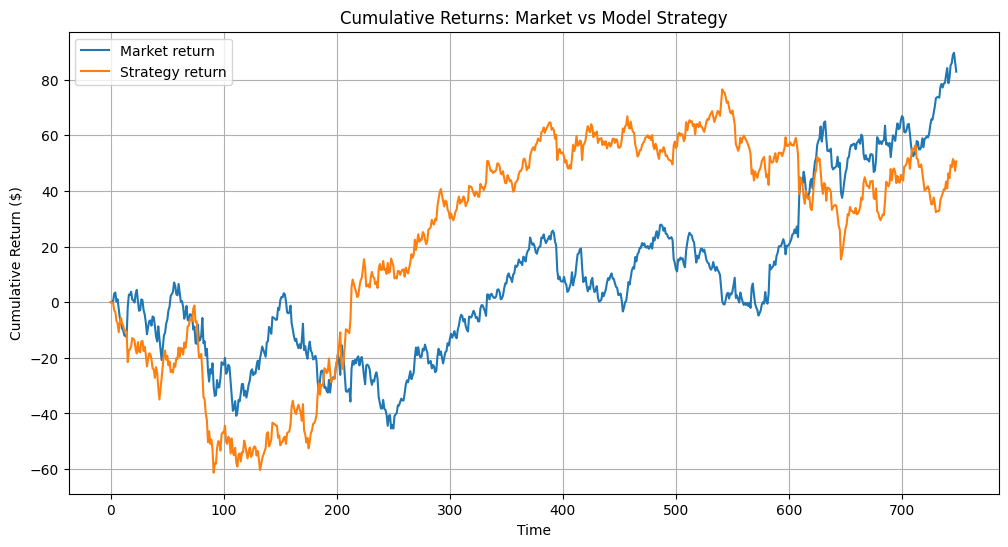

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(returns), label="Market return")
plt.plot(cumulative_returns, label="Strategy return")
plt.title("Cumulative Returns: Market vs Model Strategy")
plt.xlabel("Time")
plt.ylabel("Cumulative Return ($)")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# Approximate number of trading days in a year
trading_days = 252

# Compute daily return from cumulative series
daily_strategy_return = strategy_returns
daily_market_return = returns

# Annualized return = (1 + daily mean return) ** trading_days - 1
strategy_annualized = (1 + daily_strategy_return.mean()) ** trading_days - 1
market_annualized = (1 + daily_market_return.mean()) ** trading_days - 1

print(f"Annualized return of strategy: {strategy_annualized:.2%}")
print(f"Annualized return of market: {market_annualized:.2%}")


Annualized return of strategy: 1421474275.26%
Annualized return of market: 30619719224911.26%


In [11]:
from model import train_model_with_tuning

model2, X_test2, y_test2, y_pred2, rmse2, best_params = train_model_with_tuning(df)
print("Tuned model RMSE:", rmse2)
print("Best parameters:", best_params)

Tuned model RMSE: 24.371342708486043
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


In [12]:
from model import train_classification_model

clf, X_test_cls, y_test_cls, y_pred_cls, acc = train_classification_model(df)
print("Classification Accuracy (up/down):", f"{acc:.2%}")


Classification Accuracy (up/down): 46.86%


/Users/marcosalerno/stock-price-forecasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:39:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [14]:
from model import train_ensemble_classification_model

ensemble, X_test_ens, y_test_ens, y_pred_ens, acc_ens = train_ensemble_classification_model(df)
print("Ensemble Classification Accuracy (up/down):", f"{acc_ens:.2%}")


/Users/marcosalerno/stock-price-forecasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:39:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble Classification Accuracy (up/down): 47.26%


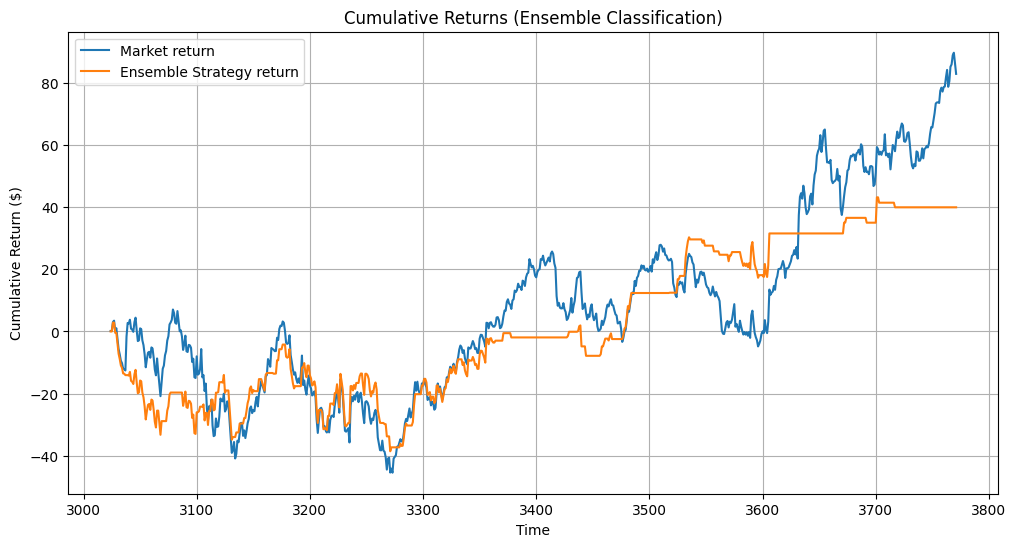

In [15]:
close_ens = df['Close'].loc[X_test_ens.index]
price_changes_ens = close_ens.shift(-1) - close_ens

strategy_ens_returns = price_changes_ens * y_pred_ens
market_ens_returns = price_changes_ens

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(market_ens_returns), label="Market return")
plt.plot(np.cumsum(strategy_ens_returns), label="Ensemble Strategy return")
plt.title("Cumulative Returns (Ensemble Classification)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return ($)")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
market_total = market_ens_returns.sum()
strategy_total = strategy_ens_returns.sum()
extra = strategy_total - market_total
rel_gain = (strategy_total / market_total - 1) * 100

print(f"Strategy total return: ${strategy_total:.2f}")
print(f"Market total return:   ${market_total:.2f}")
print(f"Extra gain:            ${extra:.2f}")
print(f"Relative gain:         {rel_gain:.2f}%")


Strategy total return: $39.95
Market total return:   $82.88
Extra gain:            $-42.93
Relative gain:         -51.80%


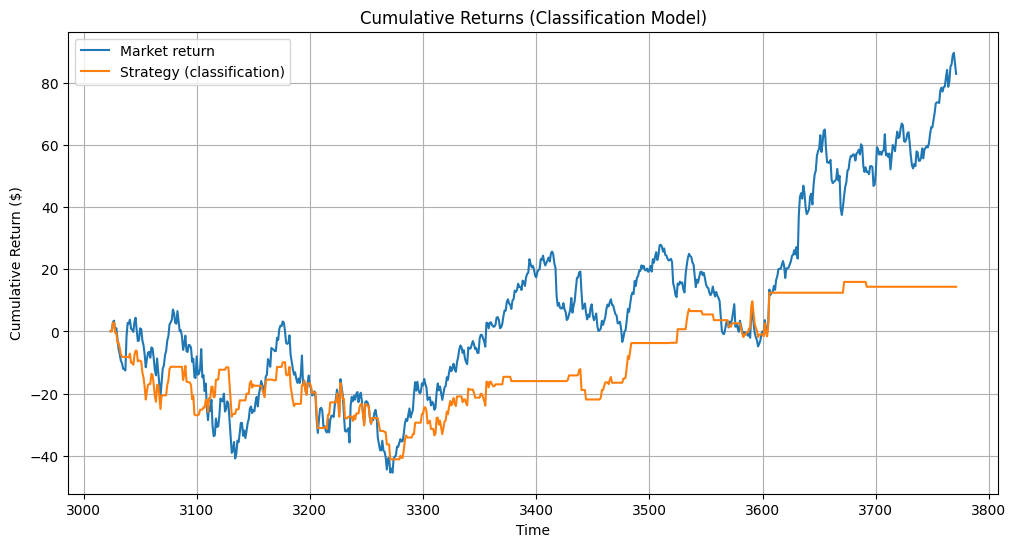

In [17]:
# Simulated strategy from classification prediction
# 1 = buy, 0 = no action
close = df['Close'].loc[X_test_cls.index]
price_changes = close.shift(-1) - close

strategy_cls_returns = price_changes * y_pred_cls
market_cls_returns = price_changes

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(market_cls_returns), label="Market return")
plt.plot(np.cumsum(strategy_cls_returns), label="Strategy (classification)")
plt.title("Cumulative Returns (Classification Model)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return ($)")
plt.legend()
plt.grid(True)
plt.show()
